In [48]:
import numpy as np
import tensorflow as tf
import spektral
import matplotlib.pyplot as plt
import random

In [49]:
dataset = spektral.datasets.Citation("cora")

c:\users\jianr\miniconda3\lib\site-packages\scipy\sparse\_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [50]:
adj_matrix = dataset[0].a.todense() + np.eye(dataset[0].n_nodes) # add self loop
adj_matrix = adj_matrix.astype('float32') # 2708 * 2708 # citation relationships
node_features = dataset[0].x # 2708 * 1433, 1433 terms noted for each paper
node_labels = dataset[0].y # 2708 * 7, 7 classes for node classification
train_mask = dataset.mask_tr
val_mask = dataset.mask_va
test_mask = dataset.mask_te

In [51]:
def softmax_cross_entropy(logits, labels, mask):
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)

In [52]:
def accuracy(logits, labels, mask):
    # equivalent expression: np.sum(accuracy_all*mask)/np.sum(mask)
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy_all = tf.cast(correct_prediction, tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask) # adjust mask proportion to sum up to 2708
    accuracy_all *= mask # apply mask to accuracy
    return tf.reduce_mean(accuracy_all) # eq. sum of accuracy / 2708

In [53]:
def gnn(node_features, adj_matrix, transform, activation):
    # aggregate neighbor features first, then weight
    aggregated_features = tf.matmul(adj_matrix, node_features) # aggregated neighbor node features: A X
    weighted_features = transform(aggregated_features) # apply weights to node features: A X W
    return activation(weighted_features) # apply activation function

In [54]:
def train_cora(node_features, adj_matrix, gnn, hidden_units_1, hidden_units_2, epochs, learning_rate, train_mask):
    layer_1 = tf.keras.layers.Dense(hidden_units_1) # hidden layer: apply weights
    layer_2 = tf.keras.layers.Dense(hidden_units_2) # hidden layer: apply weights
    output = tf.keras.layers.Dense(7) # 7 classes for nodes
    
    def cora_gnn(node_features, adj_matrix):
        hidden_1 = gnn(node_features, adj_matrix, layer_1, tf.nn.relu)
        hidden_2 = gnn(hidden_1, adj_matrix, layer_2, tf.nn.relu)
        logits = output(hidden_2)
        return logits
    
    optimizer = tf.keras.optimizers.Adam(learning_rate) # use Adam optimizer
    
    best_accuracy = 0.0
    test_acc = 0.0
    for ep in range(epochs + 1):
        with tf.GradientTape() as t:
            logits = cora_gnn(node_features, adj_matrix)
            loss = softmax_cross_entropy(logits, node_labels, train_mask)
            variables = t.watched_variables()
            grads = t.gradient(loss, variables)
            optimizer.apply_gradients(zip(grads, variables)) # apply gradients to variables
            val_accuracy = accuracy(logits, node_labels, val_mask)
            test_accuracy = accuracy(logits, node_labels, test_mask)
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                test_acc = test_accuracy
                val_loss = softmax_cross_entropy(logits, node_labels, val_mask)
                print('Epoch', ep, '| Training loss:', loss.numpy(), '| Val accuracy:'
                      , val_accuracy.numpy(), '| Val loss', val_loss.numpy(), '| Test accuracy', test_accuracy.numpy())
    return best_accuracy, test_acc

In [64]:
# GCN: D^-0.5 A D^-0.5 H W
deg_matrix = tf.reduce_sum(adj_matrix, axis=-1)
norm_deg_matrix = tf.linalg.diag(1.0 / tf.sqrt(deg_matrix)) # D^-0.5
norm_adj_matrix = tf.matmul(norm_deg_matrix, tf.matmul(adj_matrix, norm_deg_matrix)) # D^-0.5 A D^-0.5
training_size = 10
train_num = training_size
val_num = int(training_size/0.85*0.15)
test_num = 1000
total = train_num + val_num + test_num
random_selection = random.sample(range(2708), total) 
train_mask = [i in random_selection[:train_num] for i in range(2708)]
val_mask = [i in random_selection[train_num:train_num + val_num] for i in range(2708)]
test_mask = [i in random_selection[train_num + val_num:] for i in range(2708)]
train_cora(node_features, norm_adj_matrix, gnn, 100, 200, 50, 0.01, train_mask)

Epoch 3 | Training loss: 0.47579166 | Val accuracy: 1.0 | Val loss 0.92123294 | Test accuracy 0.33699998


(<tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.33699998>)

# Situation 1: train, validation, test data points are mutually exclusive and random. The selection of datapoints is independent for each size.

In [65]:
val_acc, test_acc = [], []
for size in range(140, 5, -5):
    #mask = [i < size for i in range(2708)]
    training_size = size
    train_num = training_size
    val_num = int(training_size/0.85*0.15)
    test_num = 1000
    total = train_num + val_num + test_num
    random_selection = random.sample(range(2708), total) 
    mask = [i in random_selection[:train_num] for i in range(2708)]
    val_mask = [i in random_selection[train_num:train_num + val_num] for i in range(2708)]
    test_mask = [i in random_selection[train_num + val_num:] for i in range(2708)]
    print("Training size:", size)
    v, t = train_cora(node_features, norm_adj_matrix, gnn, 100, 200, 20, 0.01, mask)
    val_acc.append(v)
    test_acc.append(t)

Training size: 140
Epoch 0 | Training loss: 1.9542859 | Val accuracy: 0.08333333 | Val loss 1.9553785 | Test accuracy 0.10599999
Epoch 1 | Training loss: 1.7750382 | Val accuracy: 0.41666663 | Val loss 1.7485076 | Test accuracy 0.298
Epoch 2 | Training loss: 1.4861684 | Val accuracy: 0.45833328 | Val loss 1.4230683 | Test accuracy 0.31
Epoch 3 | Training loss: 1.1018897 | Val accuracy: 0.625 | Val loss 1.0784703 | Test accuracy 0.44599998
Epoch 4 | Training loss: 0.694541 | Val accuracy: 0.7916666 | Val loss 0.8122939 | Test accuracy 0.70799994
Epoch 5 | Training loss: 0.3687797 | Val accuracy: 0.83333325 | Val loss 0.5742284 | Test accuracy 0.79199976
Epoch 6 | Training loss: 0.15914798 | Val accuracy: 0.9166666 | Val loss 0.39706343 | Test accuracy 0.8039998
Training size: 135
Epoch 0 | Training loss: 1.9467243 | Val accuracy: 0.26086956 | Val loss 1.9390644 | Test accuracy 0.17799999
Epoch 3 | Training loss: 0.9474617 | Val accuracy: 0.39130437 | Val loss 1.4022657 | Test accuracy 0

Epoch 5 | Training loss: 0.4048938 | Val accuracy: 0.46153846 | Val loss 1.3189148 | Test accuracy 0.609
Epoch 7 | Training loss: 0.06771593 | Val accuracy: 0.5384615 | Val loss 1.1678966 | Test accuracy 0.71699995
Epoch 8 | Training loss: 0.026208745 | Val accuracy: 0.6923077 | Val loss 1.2657002 | Test accuracy 0.72299993
Training size: 70
Epoch 0 | Training loss: 1.956444 | Val accuracy: 0.08333333 | Val loss 1.9664012 | Test accuracy 0.09599999
Epoch 1 | Training loss: 1.7037072 | Val accuracy: 0.3333333 | Val loss 1.7491628 | Test accuracy 0.286
Epoch 3 | Training loss: 1.0031289 | Val accuracy: 0.41666663 | Val loss 1.4145113 | Test accuracy 0.38399997
Epoch 4 | Training loss: 0.6561454 | Val accuracy: 0.6666666 | Val loss 1.283748 | Test accuracy 0.646
Epoch 5 | Training loss: 0.3679708 | Val accuracy: 0.75 | Val loss 1.1141803 | Test accuracy 0.686
Epoch 6 | Training loss: 0.17833038 | Val accuracy: 0.83333325 | Val loss 1.0661587 | Test accuracy 0.692
Training size: 65
Epoch 0

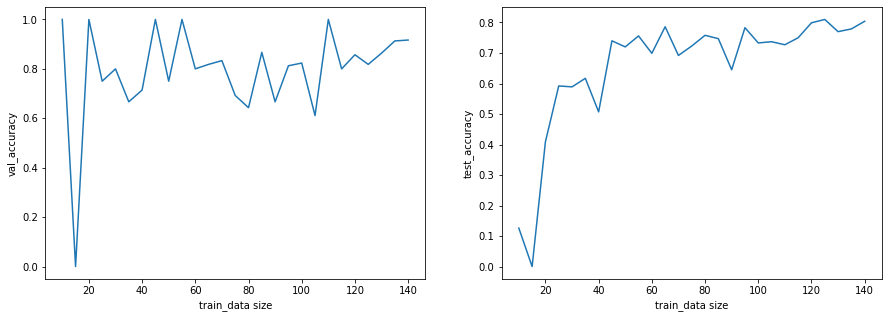

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(range(140, 5, -5), val_acc)
ax1.set_xlabel("train_data size")
ax1.set_ylabel("val_accuracy")

ax2.plot(range(140, 5, -5), test_acc)
ax2.set_xlabel("train_data size")
ax2.set_ylabel("test_accuracy")
plt.show()

# Situation 2: train, validation, test data points are mutually exclusive and selected by provided mask. The selection of validation and test datapoints remains the same for each size. The selection of training datapoints is subset of the 140 standard mask for each size.

In [67]:
val_acc, test_acc = [], []
val_mask = dataset.mask_va
test_mask = dataset.mask_te
for size in range(140, 5, -5):
    mask = [i < size for i in range(2708)]
    #training_size = size
    #train_num = training_size
    #val_num = int(training_size/0.85*0.15)
    #test_num = 1000
    #total = train_num + val_num + test_num
    #random_selection = random.sample(range(2708), total) 
    #mask = [i in random_selection[:train_num] for i in range(2708)]
    #val_mask = [i in random_selection[train_num:train_num + val_num] for i in range(2708)]
    #test_mask = [i in random_selection[train_num + val_num:] for i in range(2708)]
    print("Training size:", size)
    v, t = train_cora(node_features, norm_adj_matrix, gnn, 100, 200, 20, 0.01, mask)
    val_acc.append(v)
    test_acc.append(t)

Training size: 140
Epoch 0 | Training loss: 1.9473515 | Val accuracy: 0.19999999 | Val loss 1.9423332 | Test accuracy 0.21299998
Epoch 1 | Training loss: 1.7458186 | Val accuracy: 0.608 | Val loss 1.8525066 | Test accuracy 0.63100004
Epoch 2 | Training loss: 1.3402264 | Val accuracy: 0.72400004 | Val loss 1.6231985 | Test accuracy 0.73399997
Epoch 3 | Training loss: 0.7880207 | Val accuracy: 0.73999995 | Val loss 1.2694418 | Test accuracy 0.7649999
Epoch 4 | Training loss: 0.34336543 | Val accuracy: 0.774 | Val loss 0.9022359 | Test accuracy 0.7959999
Epoch 5 | Training loss: 0.12227352 | Val accuracy: 0.782 | Val loss 0.70923734 | Test accuracy 0.8079998
Training size: 135
Epoch 0 | Training loss: 1.9520402 | Val accuracy: 0.058 | Val loss 1.9536945 | Test accuracy 0.08699999
Epoch 1 | Training loss: 1.7684118 | Val accuracy: 0.54399997 | Val loss 1.8605334 | Test accuracy 0.55799997
Epoch 2 | Training loss: 1.366663 | Val accuracy: 0.67200005 | Val loss 1.6536875 | Test accuracy 0.70

Epoch 5 | Training loss: 0.2219809 | Val accuracy: 0.726 | Val loss 0.9007238 | Test accuracy 0.741
Epoch 6 | Training loss: 0.09173317 | Val accuracy: 0.74399996 | Val loss 0.78506 | Test accuracy 0.76099986
Epoch 7 | Training loss: 0.03687916 | Val accuracy: 0.76400006 | Val loss 0.7851743 | Test accuracy 0.78299993
Training size: 85
Epoch 0 | Training loss: 1.9455905 | Val accuracy: 0.09599999 | Val loss 1.943759 | Test accuracy 0.12099999
Epoch 1 | Training loss: 1.7244626 | Val accuracy: 0.31799996 | Val loss 1.7966218 | Test accuracy 0.32099998
Epoch 2 | Training loss: 1.391571 | Val accuracy: 0.34800002 | Val loss 1.6136577 | Test accuracy 0.35799998
Epoch 3 | Training loss: 0.9755661 | Val accuracy: 0.58599997 | Val loss 1.4195557 | Test accuracy 0.601
Epoch 4 | Training loss: 0.5865063 | Val accuracy: 0.66 | Val loss 1.2042598 | Test accuracy 0.646
Epoch 5 | Training loss: 0.30917558 | Val accuracy: 0.72599995 | Val loss 1.0085932 | Test accuracy 0.73399997
Epoch 6 | Training 

Epoch 6 | Training loss: 0.12729551 | Val accuracy: 0.66 | Val loss 1.194081 | Test accuracy 0.652
Epoch 7 | Training loss: 0.04900267 | Val accuracy: 0.678 | Val loss 1.0647482 | Test accuracy 0.691
Epoch 8 | Training loss: 0.013924725 | Val accuracy: 0.73399997 | Val loss 0.9644047 | Test accuracy 0.741
Epoch 9 | Training loss: 0.0032200986 | Val accuracy: 0.74999994 | Val loss 0.93696755 | Test accuracy 0.75799984
Epoch 10 | Training loss: 0.00093720335 | Val accuracy: 0.762 | Val loss 0.9985678 | Test accuracy 0.76100004
Training size: 40
Epoch 0 | Training loss: 1.9419487 | Val accuracy: 0.156 | Val loss 1.9429798 | Test accuracy 0.13599999
Epoch 1 | Training loss: 1.6223032 | Val accuracy: 0.31599998 | Val loss 1.8021835 | Test accuracy 0.319
Epoch 2 | Training loss: 1.1974399 | Val accuracy: 0.31799996 | Val loss 1.7109861 | Test accuracy 0.319
Epoch 3 | Training loss: 0.7562749 | Val accuracy: 0.39399996 | Val loss 1.5976949 | Test accuracy 0.39400002
Epoch 4 | Training loss: 0

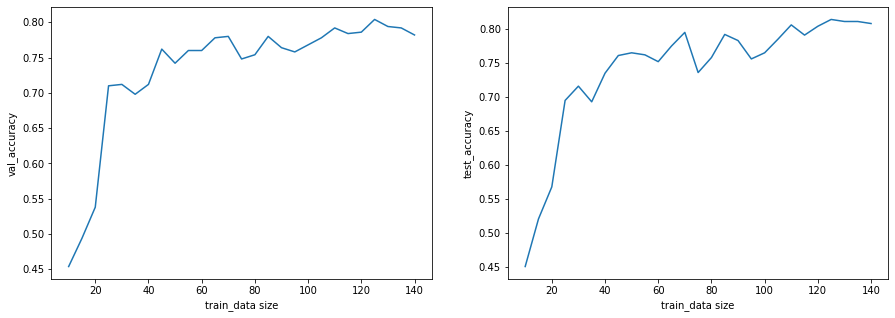

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(range(140, 5, -5), val_acc)
ax1.set_xlabel("train_data size")
ax1.set_ylabel("val_accuracy")

ax2.plot(range(140, 5, -5), test_acc)
ax2.set_xlabel("train_data size")
ax2.set_ylabel("test_accuracy")
plt.show()

In [11]:
class GraphConvLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        hidden_units,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.update_fn = tf.keras.layers.Dense(hidden_units)
        self.hidden_units = hidden_units

    def aggregate(self, node_features, adj_matrix):
        # aggregated neighbor node features
        aggregated_features = tf.matmul(adj_matrix, node_features)
        
        return aggregated_features

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """
        print("num:", self.hidden_units)
        node_repesentations, adj_matrix = inputs
        # Aggregate the neighbour messages.
        aggregated_features = self.aggregate(node_repesentations, adj_matrix)
        # Update the node embedding with the weights.
        return self.update_fn(aggregated_features)

In [12]:
class GCNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        *args,
        **kwargs,
    ):
        super(GCNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, adj_matrix = graph_info
        self.node_features = node_features
        self.adj_matrix = adj_matrix

        # Create the convoluted layer.
        self.conv = tf.keras.layers.Dense(hidden_units, name="graph_conv1")
        self.conv2 = tf.keras.layers.Dense(hidden_units, name="graph_conv2")
        # Create a compute logits layer.
        self.compute_logits = tf.keras.layers.Dense(num_classes, name="logits")

    def call(self, input_node_indices):
        # GCN layer.
        x = self.conv((self.node_features))
        x1 = self.conv2((x))
        # Classification layer
        x2 = self.compute_logits((x1))
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.squeeze(tf.gather(x2, input_node_indices))
        return node_embeddings

In [13]:
gnn_model = GCNNodeClassifier(
    graph_info=(node_features, adj_matrix),
    num_classes=7,
    hidden_units=32,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[-0.0836966   0.11248968 -0.1442203  -0.0664811  -0.07141479  0.05809357
  -0.3846781 ]
 [ 0.17265607 -0.08273803  0.21110624 -0.11755716  0.38557488 -0.00580052
  -0.15183699]
 [ 0.03180698 -0.02962838  0.17241983 -0.19746263  0.35833874 -0.23873833
   0.09629205]], shape=(3, 7), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
graph_conv1 (Dense)          multiple                  45888     
_________________________________________________________________
graph_conv2 (Dense)          multiple                  1056      
_________________________________________________________________
logits (Dense)               multiple                  231       
Total params: 47,175
Trainable params: 47,175
Non-trainable params: 0
_________________________________________________________________
